# 03. Kaplan-Meier 생존곡선과 로그순위검정
# 

### 3-1 KM 생존곡선

install.packages("pak")
pak::pkg_install("r-lib/rlang")
devtools::install_github("cardiomoon/howto")
devtools::install_github("kassambara/ggpubr")

In [17]:
library(autoReg)
library(survival)
library(survminer)
library(howto)
library(flextable)
library(ftExtra)
library(tidyverse)
library(tidymodels)
tidymodels::tidymodels_conflicts()

── Conflicts ───────────────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::compose()  masks flextable::compose()
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

# 
#### anderson 데이터 : 42명의 백혈병 환자 데이터로
- **```time```**은 추적 기간
- **```status```** : 재발한 경우는 1, 재발하지 않은 경우(중도절단)
- **```sex```** : 성별
- **```logWBC```** : 백혈구 숫자의 로그값
- **```rx```** : 치료군은 0, 대조군은 1 
    - **콕스모형에서는 대조군을 1, 치료군을 0으로 표현. 위험비가 1보다 큰 것을 해석하는 것이 직관적이기**

In [18]:
data = subset(anderson, rx == 0)

# 
- 중도절단된 자료에는 숫자에 '+'를 붙여 중도절단임을 표시

### ```Surv()```

In [19]:
with(data, Surv(time, status))

 [1] 35+ 34+ 32+ 32+ 25+ 23  22  20+ 19+ 17+ 16  13  11+ 10+ 10   9+  7   6+  6 
[20]  6   6 

# 
#### **평균생존시간 $\bar{T}$** : 중도절단을 고려하지 않은, 생존시간의 평균
    - 중도절단된 자료는 정확한 생존시간을 알 수 없으므로, 실제 생존시간은 평균생존시간보다 길다
#### **평균 위험률 (average hazard rate, $\bar{h}$)** : 전체 실패 수 (재발)를 생존시간의 합계로 나눈 값

# 
- 치료군(rx = 0)에서 평균생존시간이 더 길고 평균위험률이 더 낮음

In [20]:
anderson %>% group_by(rx) %>% summarise(T = mean(time), h = sum(status) / sum(time))

rx,T,h
<dbl>,<dbl>,<dbl>
0,17.095238,0.02506964
1,8.666667,0.11538462


- 치료군의 데이터를 대상으로 생존율을 계산
# 

### ```survfit()```

# 

#### **median survival (생존율이 50%인 시간)의 95% 신뢰구간**

In [21]:
fit = survfit(Surv(time, status) ~ 1, data = data)
fit 

Call: survfit(formula = Surv(time, status) ~ 1, data = data)

      n events median 0.95LCL 0.95UCL
[1,] 21      9     23      16      NA

# 
- 각 시점별 생존율과 95% 신뢰구간

In [22]:
tidy(fit)

time,n.risk,n.event,n.censor,estimate,std.error,conf.high,conf.low
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,21,3,1,0.8571429,0.08908708,1.0000000,0.7198171
7,17,1,0,0.8067227,0.10776353,0.9964437,0.6531242
9,16,0,1,0.8067227,0.10776353,0.9964437,0.6531242
10,15,1,1,0.7529412,0.12796438,0.9675748,0.5859190
11,13,0,1,0.7529412,0.12796438,0.9675748,0.5859190
13,12,1,0,0.6901961,0.15475995,0.9347692,0.5096131
16,11,1,0,0.6274510,0.18177335,0.8959949,0.4393939
17,10,0,1,0.6274510,0.18177335,0.8959949,0.4393939
19,9,0,1,0.6274510,0.18177335,0.8959949,0.4393939


# 
#### 생존율의 95% 신뢰구간
#### $\hat{S}(t)\pm 1.96\times \sqrt{\hat{Var}(\hat{S}(t))}$

# 
#### 생존율의 추정분산 $\hat{Var}(\hat{S}(t))$
#### $\hat{Var}(\hat{S}(t)) = (\hat{S}(t))^2 \;\times\; \sum_{f:\;t_{f} \leq t} \;[{(m_f)\over {n_f (n_f - m_f)}}]$
- $t_{(f)}$ : 실패시간
- $m_{f}$ : $t_f$에서의 실패수
- $n_f$ : t_{(f)}에서의 number at risk

# 
# 
### 생존율 계산 원리

| time | n.risk | n.event | n.censor |  | surv |
| - | - | - | - | - | - |
| 0 | 21 | 0 | 0 |  | 1.0 |
| 6 | 21 | 3 | 1 | $1.0\;\times\;(18\div21)$ | 0.8571 |
| 7 | 17 | 1 | 0 | $0.8571\;\times\;(16\div17)$ | 0.8067 |
| 10 | 15 | 1 | 2 | $0.8067\;\times\;(14\div15)$ | 0.7529 |
| 13 | 12 | 1 | 1 | $0.7529\;\times\;(11\div12)$ | 0.6902 |
| 16 | 11 | 1 | 0 | $0.6902\;\times\;(10\div11)$ | 0.6275 |
| 22 | 7 | 1 | 3 | $0.6275\;\times\;(6\div7)$ | 0.5378 |
| 23 | 6 | 1 | 0 | $0.5378\;\times\;(5\div6)$ | 0.4482 |

# 

- 연구 시작 시점에서 대상환자수(number at risk, ```n.risk```) = 21
    - 이벤트가 발생하지 않았으므로 (```n.event``` = 0)
- 6주째에 3명에게 이벤트가 발생 -> 6주차의 **```n.risk``` = 21** => 이벤트가 발생한 3명을 제외하고 18명 생존
    - **6주차의 생존율 : $\hat{S}(6) = 1 \; \times {{(21-3)} \over {21}} = 1\times {18 \over 21} = 0.8571$** = $P(T > 6 | T \geq 6) = {18 \over 21}$ = **6주까지 살아 있는 사람 중 6주를 초과하여 살아 있는 사람의 비율**

- 13주차의 생존율 : $\hat{S}(13) = 1\;\times\;{18 \over 21} \times {16 \over 17} \times {14 \over 15} \times {11 \over 12} = 0.6902$

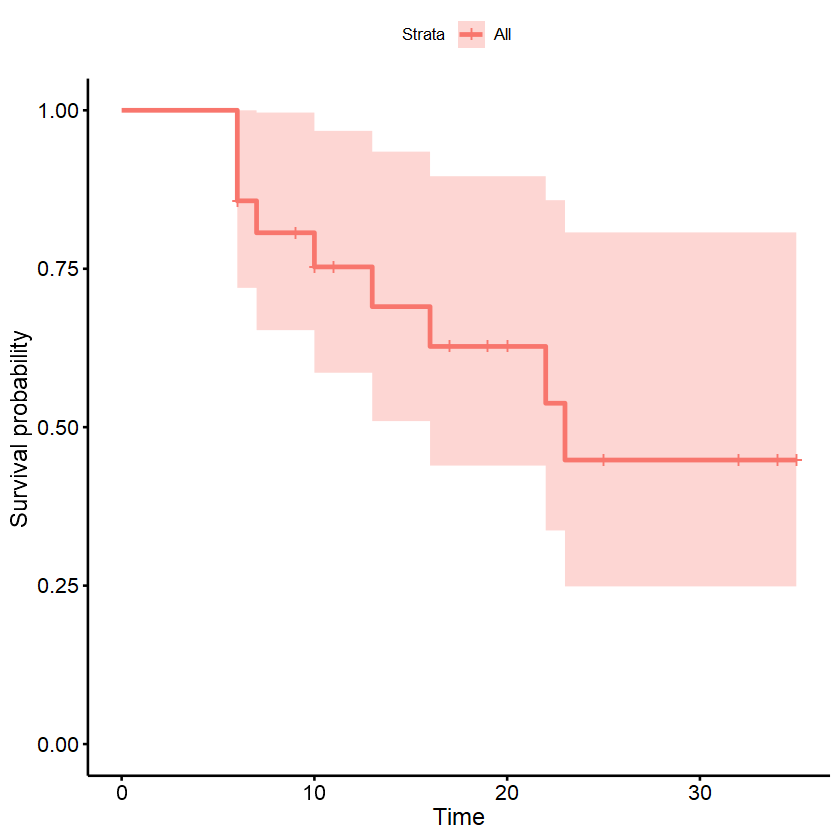

In [23]:
ggsurvplot(fit, data=data)

# 
#### KM 생존율의 일반화
- **f번째 시간 $t_{f}$의 생존율 : 그 시간 전까지의 추정생존율에 조건부확률을 곱한 값**
#### $\hat{S}(t_{(f)}) = \hat{S}(t_{(f-1)}) \times \hat{P}(T > t_{(f)} | T \geq t_{(f)})$ 

# 

#### KM 생존율 승법극한추정량 (product limit estimator)
#### $\hat{S}(t_{(f)}) = \Pi^f_{i=1}\hat{P}(T > t_{(f)}|T \geq t_{(f)})$

# 
# 
### 3-2 로그순위검정
#### 두 군 간의 KM 생존곡선 비교

# 
### 로그순위검정(log-rank test) : 2개의 생존곡선이 통계적으로 동등한지 검정
#### 귀무가설 : 두 곡선은 동등하다

# 

- **2개의 생존곡선이 통계적으로 동등하다는 것은 true survival curve가 다르다는 근거가 없다는 뜻**
- 로그순위검정은 2개의 생존곡선을 전체적으로 비교하기 위해,**각각의 시간에서 두 군의 기대값과 관찰값의 차이를 구하여, 검정통계량을 계산하는 카이제곱 검정**

In [24]:
fit1 = survfit(Surv(time, status) ~ rx, data = anderson1)

In [25]:
tidy(fit1)

time,n.risk,n.event,n.censor,estimate,std.error,conf.high,conf.low,strata
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
6,21,3,1,0.85714286,0.08908708,1.0000000,0.71981708,rx=Treatment
7,17,1,0,0.80672269,0.10776353,0.9964437,0.65312422,rx=Treatment
9,16,0,1,0.80672269,0.10776353,0.9964437,0.65312422,rx=Treatment
10,15,1,1,0.75294118,0.12796438,0.9675748,0.58591898,rx=Treatment
11,13,0,1,0.75294118,0.12796438,0.9675748,0.58591898,rx=Treatment
13,12,1,0,0.69019608,0.15475995,0.9347692,0.50961310,rx=Treatment
16,11,1,0,0.62745098,0.18177335,0.8959949,0.43939392,rx=Treatment
17,10,0,1,0.62745098,0.18177335,0.8959949,0.43939392,rx=Treatment
19,9,0,1,0.62745098,0.18177335,0.8959949,0.43939392,rx=Treatment


# 
- **로그순위검정 통계량 : 16.8 (자유도 1인 카이제곱분포를 따름)**
    - 자유도 df = n-1 (n = 군의 개수)
- **p-value < 0.05 => 두 곡선은 동등하지 않음**

### ```survdiff()```

Call:
survdiff(formula = Surv(time, status) ~ rx, data = anderson1)

              N Observed Expected (O-E)^2/E (O-E)^2/V
rx=Treatment 21        9     19.3      5.46      16.8
rx=Control   21       21     10.7      9.77      16.8

 Chisq= 16.8  on 1 degrees of freedom, p= 4e-05 

[1] 4.15333e-05

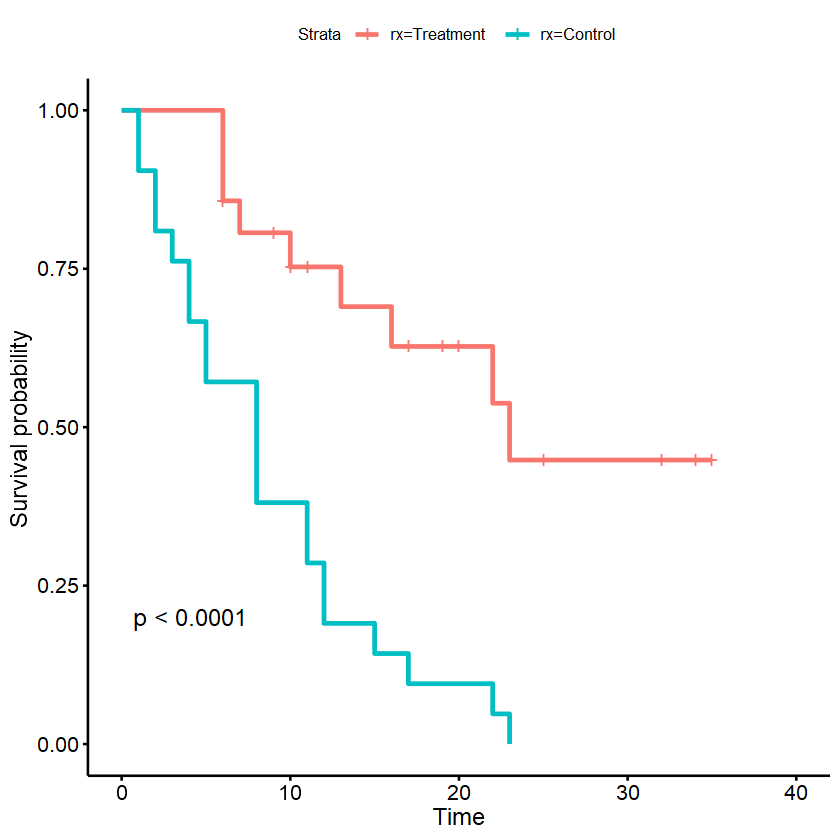

In [26]:
survdiff(Surv(time, status) ~ rx, anderson1)
pchisq(16.8, df = 1, lower.tail = F)
ggsurvplot(fit1, anderson1, pval = T)

# 

- **```t```** : 시간
- **```f1```, ```f2```** : 대조군과 치료군의 실패 수
- **```n1```. ```n2```** : 대조군과 치료군의 number at risk
- **```e1f```, ```e2f```** : 대조군과 치료군에서 실패 기댓값
    - **e1f$ = (n1 / (n1 + n2)) \times (n1 + n2)$**
    - **e2f$ = (n2 / (n1 + n2)) \times (n1 + n2)$**
- **```f1-e1f```. ```f2-e2f```** : 관찰값 - 기댓값
- **```varOE```** : '관찰값 - 기댓값'의 분산|
    - $Var(O_i - E_i) = {{n1n2(f1+f2)(n1+n2-f1-f2} \over {(n1+n2)^2(n1-n2-1)}}$
# 

| **f1** | **f2** | **n1** | **n2**| **e1f** | **e2f** | **f1-e1f** | **f2-e2f** | **varOE** |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ----: | 
| 2 | 0 | 21 | 21 | (21$\;\div\;$42)$\;\times\;2$ | (21$\;\div\;$42)$\;\times\;$2 | 1.0 | -1.0 | | 0.49 | 
| 2 | 0 | 19 | 21 | (19$\;\div\;$40)$\;\times\;2$ | (21$\;\div\;$40)$\;\times\;$2 | 1.05 | -1.05 | | 0.49 | 
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |$\vdots$ | $\vdots$ |

# 
#### 로그순위검정량(log-rank statistic) : $Log-rank statistic = {{(O_2 - E_2)^2} \over {Var(O_2 - E_2)}} = {{(-10.25)^2} \over {6.26}} \approx 16.79$

# 
# 
#### 세 군 이상인 경우의 로그순위검정
**귀무가설** : 모든 생존곡선이 동등하다

In [27]:
data(cancer, package = "survival")
survdiff(Surv(time, status) ~ rx, data = colon)

Call:
survdiff(formula = Surv(time, status) ~ rx, data = colon)

             N Observed Expected (O-E)^2/E (O-E)^2/V
rx=Obs     630      345      299      7.01     10.40
rx=Lev     620      333      295      4.93      7.26
rx=Lev+5FU 608      242      326     21.61     33.54

 Chisq= 33.6  on 2 degrees of freedom, p= 5e-08 

#### $\chi^2 = \sum^n_{i=1} {{(O_i - E_i)^2} \over {E_i}}$ = 33.6

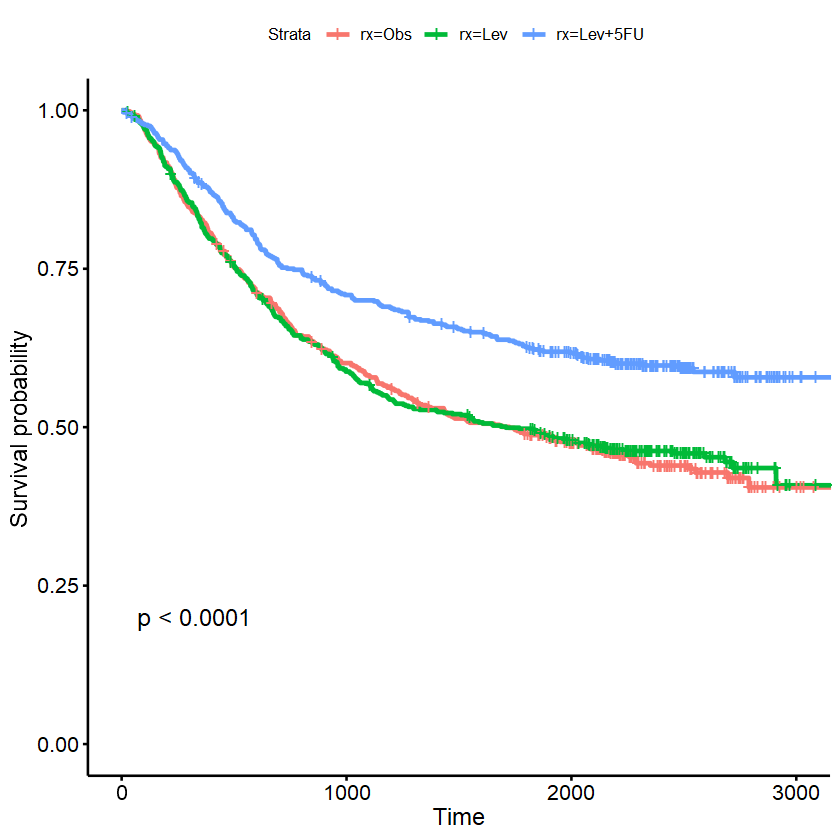

In [28]:
fit2 = survfit(Surv(time, status) ~ rx, data = colon)
ggsurvplot(fit2, pval = T)

# 
# 
#### 로그순위검정의 대안
- Wilcoxon, Tarone-Ware, Peto, Flemington-Harrington 검정 등 : 초기 실패에 더 가중치

#### $Test\;statistic = {{(\sum_f w(t_f) (O_i - E_i))^2}\over {Var(\sum_f w(t_f)(O_i - E_i))}}$

$W(t_f) = weight\;at\;fth\;failure\;time$

# 

| Test Statistic | $w(t_f)$ |
| - | - |
| Log Rank | $1$ |
| Wilcoxon | $n_f$ |
| Tarone-Ware | $\sqrt{n_f}$ |
| Peto | $s(t_f)$ | 
| Flemington-Harrington | $S(t_{f1})^P\times[1\;-\;S(t_{(f1)})]^q$ |

# 
- 로그순위검정 결과 귀무가설 기각 X

In [29]:
data(pancreatic2, package = "asaur")
(fit4 = survdiff(Surv(pfs) ~ stage, data = pancreatic2))

Call:
survdiff(formula = Surv(pfs) ~ stage, data = pancreatic2)

          N Observed Expected (O-E)^2/E (O-E)^2/V
stage=LA  8        8     12.3      1.49      2.25
stage=M  33       33     28.7      0.64      2.25

 Chisq= 2.2  on 1 degrees of freedom, p= 0.1 

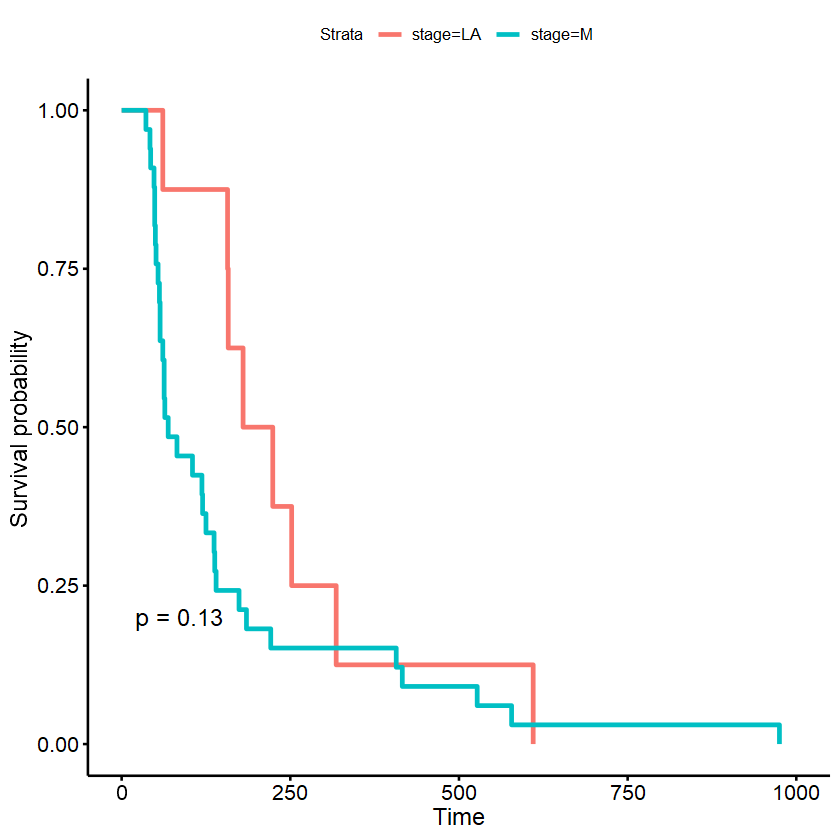

In [30]:
fit4 = survfit(Surv(pfs) ~ stage, data = pancreatic2)
ggsurvplot(fit4, data = pancreatic2, pval = T)

# 
- **```survdiff()```의 ```rho```에 1을 설정하면, Peto 수정방법으로 검정**
- => **P < 0.05 -> 귀무가설 기각**
    - (초기 생존시간에 가중치를 주기 때문 => 초기 생존에 유리한 것으로 나타남)

In [31]:
survdiff(Surv(pfs) ~ stage, data = pancreatic2, rho = 1)

Call:
survdiff(formula = Surv(pfs) ~ stage, data = pancreatic2, rho = 1)

          N Observed Expected (O-E)^2/E (O-E)^2/V
stage=LA  8     2.34     5.88     2.128      4.71
stage=M  33    18.76    15.22     0.822      4.71

 Chisq= 4.7  on 1 degrees of freedom, p= 0.03 

# 
- ```ggsurvplot()```의 ```log.rank.weights```를 S1로 Peto 통계량 반영
    - 1 : log-rank 
    - n : Gehan-Breslow (generalized Wilcoxon) 
    - sqrtN : Tarone-Ware 
    - S1 : Peto-Peto's modified survival estimate 
    - S2 : modified Peto-Peto (by Andersen) 
    - FH : Fleming-Harrington(p=1, q=1).

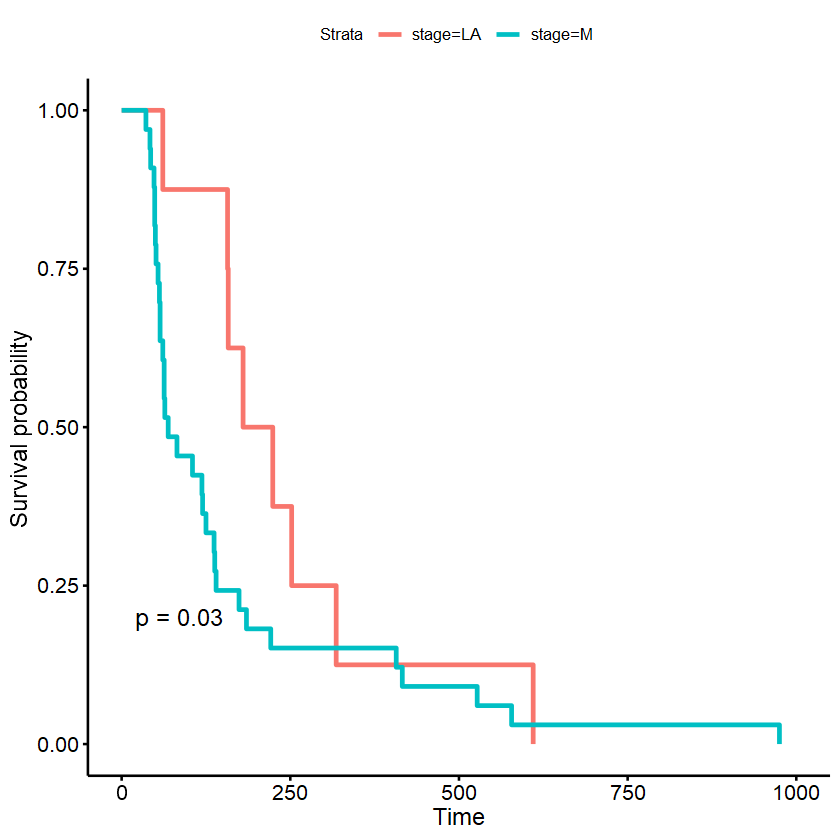

In [32]:
ggsurvplot(fit4, data = pancreatic2, pval = T, log.rank.weights = "S1")

# 
# 
#### 층화된 로그순위검정
- 두 군 간의 생존곡선을 비교할 때, 다른 공변량을 보정해야 할 경우 => 층화된 비례위험모형 사용
- **보정할 공변량이 수준이 적을 때는 층화된 로그순위검정 사용**

# 

**귀무가설 : $H_0:h_{0j}(t) = h_{1j(t)}\;\; for \; j=1, 2, ..., G$**
- 두 번째 변수의 각 수준에 대해 스코어통계량 $U_{0g}$와 분산 $V_0g$계산 (g = 1, ..., G는 첫 번째 변수의 group))
    
#### 검정통계량 : ${{\sum^G_{g=1}U_{0g})^2} \over {\sum^G_{g=1} V^2_{0g}}}\;\sim\; \chi^2_{1}$

In [33]:
data(pharmacoSmoking, package = "asaur")
survdiff(Surv(ttr, relapse) ~ grp, data = pharmacoSmoking)

Call:
survdiff(formula = Surv(ttr, relapse) ~ grp, data = pharmacoSmoking)

                 N Observed Expected (O-E)^2/E (O-E)^2/V
grp=combination 61       37     49.9      3.36      8.03
grp=patchOnly   64       52     39.1      4.29      8.03

 Chisq= 8  on 1 degrees of freedom, p= 0.005 

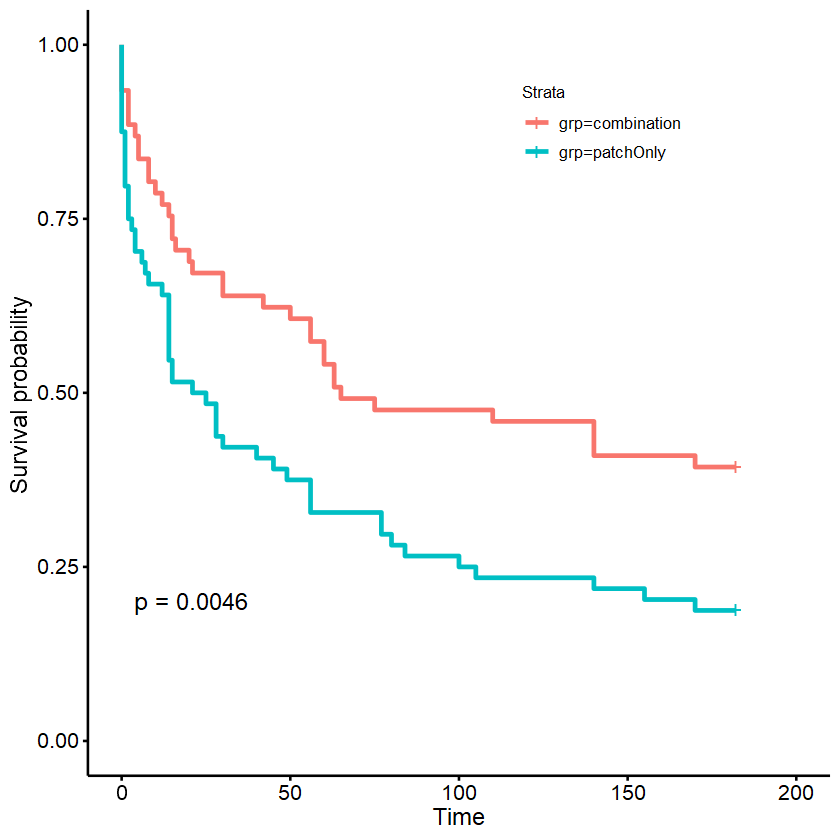

In [34]:
fit = survfit(Surv(ttr, relapse) ~ grp, data = pharmacoSmoking)
ggsurvplot(fit, data = pharmacoSmoking, pval = T, legend = c(0.7, 0.85))

# 
- 나이의 영향을 보정하기 위해 ageGroup2를 사용하여, 층화된 로그순위검정

In [35]:
survdiff(Surv(ttr, relapse) ~ grp + strata(ageGroup2), data = pharmacoSmoking)

Call:
survdiff(formula = Surv(ttr, relapse) ~ grp + strata(ageGroup2), 
    data = pharmacoSmoking)

                 N Observed Expected (O-E)^2/E (O-E)^2/V
grp=combination 61       37     49.1      2.99      7.03
grp=patchOnly   64       52     39.9      3.68      7.03

 Chisq= 7  on 1 degrees of freedom, p= 0.008 

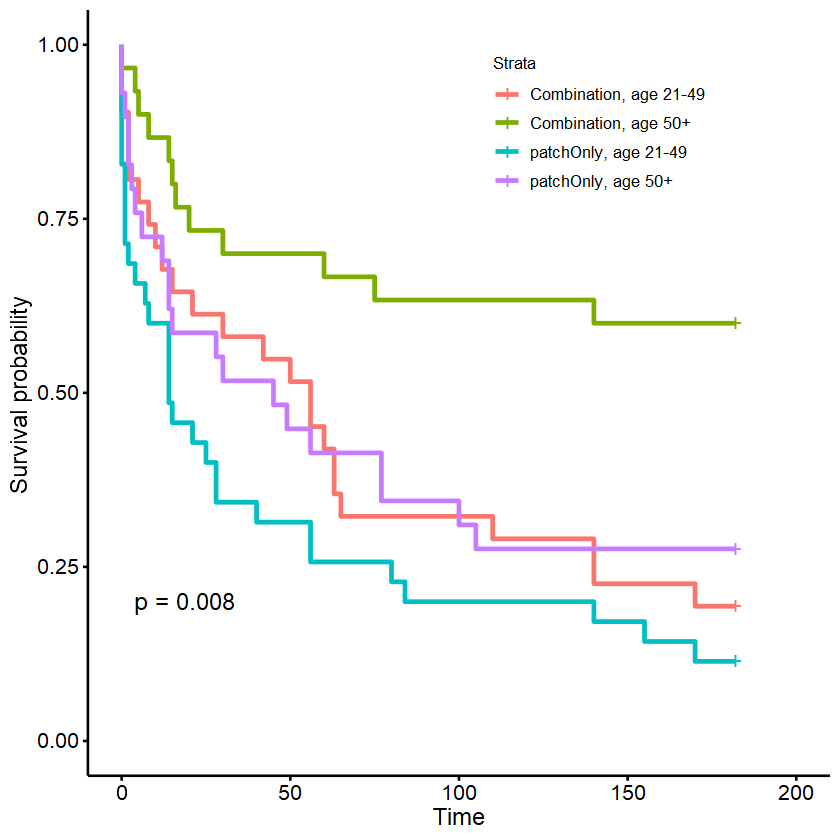

In [36]:
labs = c("Combination, age 21-49", "Combination, age 50+", "patchOnly, age 21-49", "patchOnly, age 50+")
ggsurvplot(survfit(Surv(ttr, relapse) ~ grp + strata(ageGroup2), data = pharmacoSmoking),
           data = pharmacoSmoking, legend = c(0.7, 0.85), legend.labs = labs, pval = T)

- 공변량인 ageGroup2의 효과를 보정하기 전과 보정한 후의 차이가 크지 않음 => 층화 로그순위검정 필요X

# 
# 

In [37]:
lambda.mutant.0 <- 0.03
lambda.mutant.1 <- 0.03 * 0.55
lambda.wt.0 <- 0.03 * 0.2
lambda.wt.1 <- 0.03 * 0.2 * 0.55

In [38]:
set.seed(4231)
tt.control.mutant <- rexp(25, rate = `lambda.mutant.0`)
tt.treat.mutant <- rexp(125, rate = `lambda.mutant.1`)
tt.control.wt <- rexp(125, rate = `lambda.wt.0`)
tt.treat.wt <- rexp(25, rate = `lambda.wt.1`)
ttAll <- c(tt.control.mutant, tt.treat.mutant, tt.control.wt, tt.treat.wt)

status <- rep(1, length(ttAll))
genotype <- c(rep("mutant", 150), rep("wt", 150))
trt <- c(rep(0, 25), rep(1, 125), rep(0, 125), rep(1, 25))

geneConfounder <- data.frame(ttAll, status, trt, genotype)

# 
- p-value < 0.05 => 귀무가설 기각

In [39]:
survdiff(Surv(ttAll, status) ~ trt, data = geneConfounder)

Call:
survdiff(formula = Surv(ttAll, status) ~ trt, data = geneConfounder)

        N Observed Expected (O-E)^2/E (O-E)^2/V
trt=0 150      150      184      6.16      16.3
trt=1 150      150      116      9.71      16.3

 Chisq= 16.3  on 1 degrees of freedom, p= 5e-05 

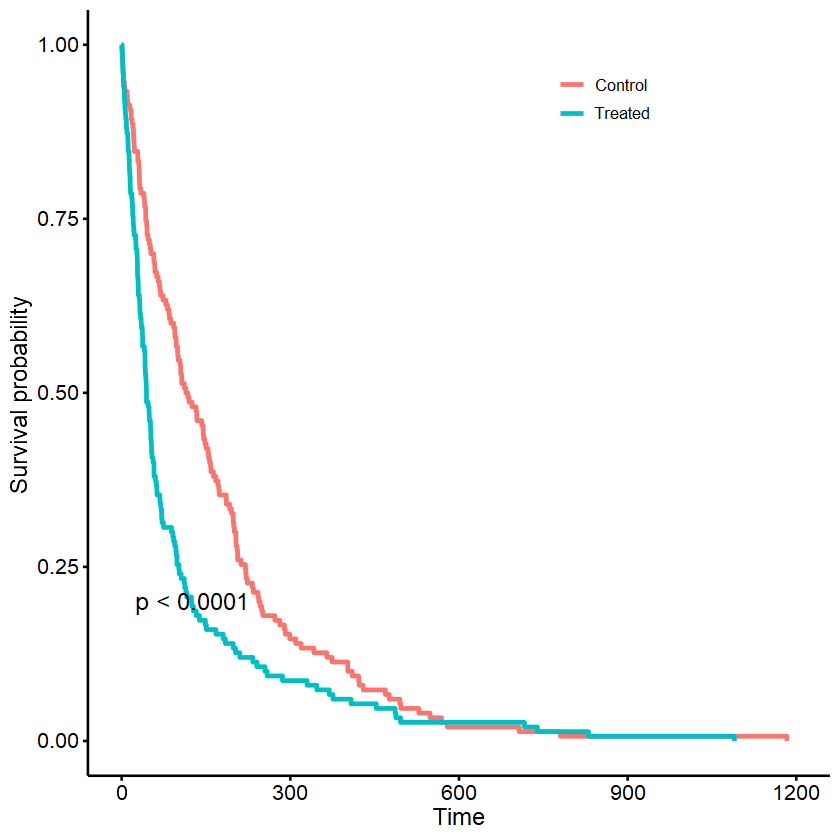

In [40]:
fit = survfit(Surv(ttAll, status) ~ trt, data = geneConfounder)
labs = c("Control", "Treated")
ggsurvplot(fit, data = geneConfounder, legend = c(0.7, 0.9), legend.title = "",
           legend.labs = labs, pval = T)

# 
- 혼동변수인 genotype의 영향을 보정하여 로그순위검정
- **p-value < 0.05 => 귀무가설 기각 => 군별, 유전자에 따라 생존확률의 유의한 차이 발생 => 유전자는 생존확률에 영향을 미치는 혼동변수**

# 

1. **치료군은 대조군에 비해 우월한 생존**
2. **wild type은 mutant에 비해 우월한 생존**
3. **치료군의 mutant의 생존확률 곡선이 가장 급격히 감소 => 치료군에 mutant가 포함되어 있어, 유전자 타입을 고려하지 않은 경우, 치료군의 생존이 더 나쁜 것으로 보임**

In [41]:
survdiff(Surv(ttAll, status) ~ trt + strata(genotype), data = geneConfounder)

Call:
survdiff(formula = Surv(ttAll, status) ~ trt + strata(genotype), 
    data = geneConfounder)

        N Observed Expected (O-E)^2/E (O-E)^2/V
trt=0 150      150      130      3.23      10.9
trt=1 150      150      170      2.46      10.9

 Chisq= 10.9  on 1 degrees of freedom, p= 0.001 

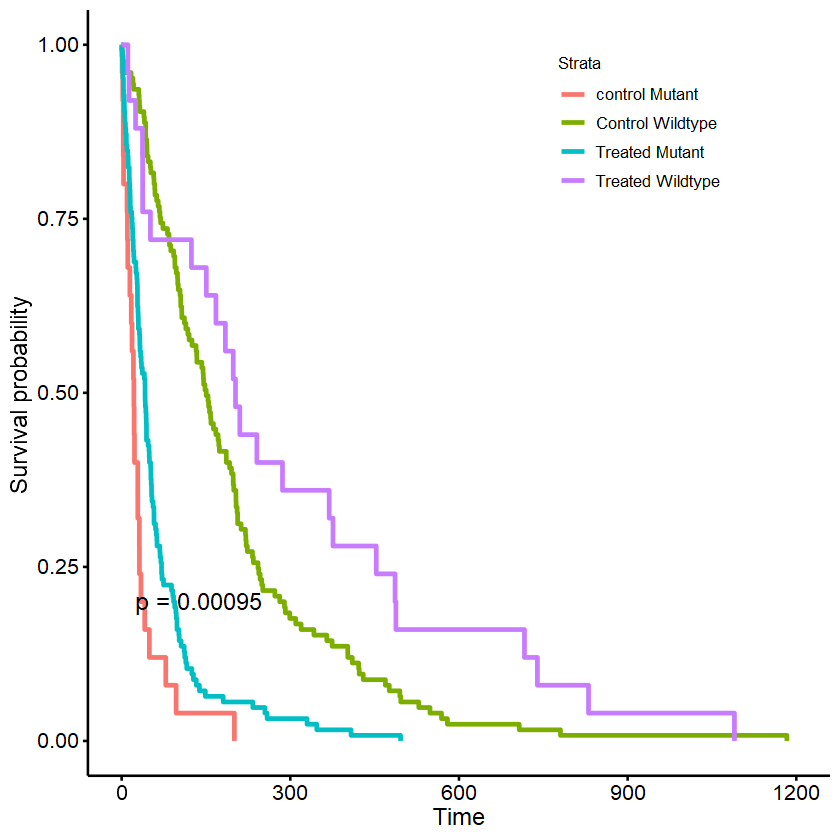

In [42]:
fit = (survfit(Surv(ttAll, status) ~ trt + strata(genotype), data = geneConfounder))
labs = c("control Mutant", "Control Wildtype", "Treated Mutant", "Treated Wildtype")
ggsurvplot(fit, geneConfounder, legend = c(0.75, 0.85), legend.labs = labs, pval = T)